# 네이버 영화 리뷰 분석

## (1) 프로젝트 개요

#### 데이터 출처
https://movie.naver.com/movie/bi/mi/basic.naver?code=190991

#### Feature 구성
* score : 관객의 평가한 점수
* comment : 관객이 작성한 리뷰 내용

#### 웹 스크래핑 코드

In [1]:
# import requests
# import math
# from bs4 import BeautifulSoup
# from openpyxl import Workbook

# wb = Workbook(write_only=True)
# ws = wb.create_sheet('naver_movie_ratings')
# ws.append(['score', 'comment'])

# url = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.naver?code=190991&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=1'
# response = requests.get(url)
# review_page = response.text

# soup = BeautifulSoup(review_page, 'html.parser')
# total_count = soup.select('body > div > div > div.score_total > strong > em')
# total_count = int(total_count[0].get_text())

# last_page = math.ceil(total_count / 10) + 1

# for page in range(1, last_page):
#     url = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.naver?code=190991&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page={}'.format(page)
#     response = requests.get(url)
#     review_page = response.text
#     soup = BeautifulSoup(review_page, 'html.parser')

#     for i in range(10):
#         review = soup.find('span', {'id': '_filtered_ment_{}'.format(i)})
#         if review is None:
#             break
#         else:
#             review = review.get_text().strip()

#             score = soup.select('body > div > div > div.score_result > ul > li:nth-child({}) > div.star_score > em'.format(i + 1))
#             score = int(score[0].get_text())

#             row = [score, review]
#             ws.append(row)

# wb.save('naver_movie_ratings.xlsx')

## (2) EDA 및 데이터 전처리

### 2-1. 데이터 불러오기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_excel('naver_movie_ratings.xlsx')
df.head()

,score,comment
0,10,최민식이 열고 최민식이 닫았다....
1,10,파이송 OST 음원 내줘요....
2,10,"어쩌면 뻔한 스토리일지도 모르지만, 우리가 원하는 세상을 이야기하는 동화. 난롯가처..."
3,7,초반엔 상당히 신선했는데 말이죠... 리학성의 사연이 드러나면서 부터는 뻔한 결말로...
4,10,역시 최민식! 올해 본 영화 중 제일 감동적이고 재밌었어요


### 2-2. 데이터 탐색

In [4]:
df.shape

(909, 2)

In [5]:
df.isnull().sum()

score       0
comment    65
dtype: int64

In [6]:
df = df.dropna(axis=0).copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844 entries, 0 to 908
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   score    844 non-null    int64 
 1   comment  844 non-null    object
dtypes: int64(1), object(1)
memory usage: 19.8+ KB


### 2-3. 한국어 텍스트 데이터 전처리

In [8]:
# konlpy 설치
!pip install konlpy==0.5.1 jpype1 Jpype1-py3

정규표현식 적용

In [9]:
# 텍스트에서 한글만 추출하기(공백 문자는 하나만 포함) => 한글과 공백이 아닌 문자를 찾아서 모두 ''으로 치환
import re

def apply_regular_expression(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]')
    result = hangul.sub('', text)
    return result

In [10]:
apply_regular_expression(df['comment'][0])

'최민식이 열고 최민식이 닫았다'

명사 형태소 추출

In [11]:
from konlpy.tag import Okt
from collections import Counter

nouns_tagger = Okt()

# 명사만 추출하기 => Okt().nouns(text)
nouns = nouns_tagger.nouns(apply_regular_expression(df['comment'][0]))

In [12]:
nouns

['최민식', '최민식']

In [13]:
# 전체 말뭉치(corpus)에서 명사 형태소 추출
nouns = nouns_tagger.nouns(apply_regular_expression("".join(df['comment'].tolist())))

In [14]:
# 빈도 탐색
counter = Counter(nouns)
counter.most_common(10)

[('영화', 378),
 ('최민식', 245),
 ('연기', 198),
 ('수학', 176),
 ('감동', 159),
 ('배우', 150),
 ('스토리', 102),
 ('역시', 61),
 ('수', 51),
 ('정말', 50)]

In [15]:
# 한 글자 길이의 명사 제거
available_counter = Counter({x : counter[x] for x in counter if len(x) > 1})
available_counter.most_common(10)

[('영화', 378),
 ('최민식', 245),
 ('연기', 198),
 ('수학', 176),
 ('감동', 159),
 ('배우', 150),
 ('스토리', 102),
 ('역시', 61),
 ('정말', 50),
 ('진짜', 46)]

불용어 사전

In [16]:
stopwords = ['가장', '역시', '정말', '모두', '내내', '영화', '느낌', '조금', '그냥', '흐름', '정형']

## (3) 텍스트 분석

### 3-1. Word Count

In [17]:
# BoW(Bag of Words) 벡터 생성 => 불용어가 아닌 형태소 추출
# BoW 인코딩은 문서를 숫자 벡터로 변환하는 가장 기본적인 방법
# CountVectorizer는 문서 집합에서 단어 토큰을 생성하고 각 단어의 수를 세어 BoW 인코딩 벡터를 생성
# fit_transform 함수를 통해 Counter Vector로 만들 수 있음

from sklearn.feature_extraction.text import CountVectorizer

def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]')
    result = hangul.sub('', text)

    nouns_tagger = Okt()
    nouns = nouns_tagger.nouns(result)

    nouns = [x for x in nouns if len(x) > 1]
    nouns = [x for x in nouns if x not in stopwords]

    return nouns

vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(df['comment'].tolist())
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis=0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
word_list[:10]

['가능', '가다가', '가뜩이나', '가라', '가면', '가무', '가미', '가설', '가슴', '가족']

In [19]:
count_list[:10]

array([ 1,  2,  1,  1,  2,  1,  1,  1, 14, 23])

In [20]:
# 844개의 문장에서 1235개의 단어가 사용됨
bow_vect.shape

(844, 1235)

In [21]:
bow_vect.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
bow_vect.toarray().sum(axis=0)[:10]

array([ 1,  2,  1,  1,  2,  1,  1,  1, 14, 23])

In [23]:
word_count_dict = dict(zip(word_list, count_list))

In [24]:
for index, (key, value) in enumerate(word_count_dict.items()):
    if index >= 10:
        break
    else:
        print(index, key, value)

0 가능 1
1 가다가 2
2 가뜩이나 1
3 가라 1
4 가면 2
5 가무 1
6 가미 1
7 가설 1
8 가슴 14
9 가족 23


### 3-2. TF-IDF

In [25]:
# TF-IDF(Term Frequency-Inverse Document Frequency) 변환 => 문서 안에서 각각의 단어의 중요도 측정
# 단어를 갯수 그대로 카운트하지 않고 모든 문서에 공통적으로 들어있는 단어의 경우 문서 구별 능력이 떨어진다고 보아 가중치를 축소하는 방법

# TF: 특정 문서에서 특정 단어의 등장 횟수
# DF: 특정 단어가 등장한 문서의 수
# IDF: DF와 반비례 값을 가지는 수식
# TF-IDF: TF와 IDF를 곱한 값

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [26]:
print(tf_idf_vect.shape)
print('=' * 40)
print(tf_idf_vect)

(844, 1235)
  (0, 1057)	1.0
  (1, 1106)	0.5697467643582297
  (1, 781)	0.8218203115665419
  (2, 1035)	0.3739674541423643
  (2, 844)	0.39680092026583574
  (2, 806)	0.26438497076892264
  (2, 750)	0.28721843689239396
  (2, 667)	0.39680092026583574
  (2, 588)	0.17763595351895228
  (2, 552)	0.32625250505115927
  (2, 269)	0.31209991986012764
  (2, 178)	0.39680092026583574
  (3, 1046)	0.2897205019827562
  (3, 545)	0.39215361658005865
  (3, 502)	0.4160974818020007
  (3, 448)	0.2646299436882588
  (3, 317)	0.36198791392703406
  (3, 55)	0.6023719311838591
  (3, 21)	0.1588214625553021
  (4, 1057)	0.25068568223010845
  (4, 947)	0.6429926645916713
  (4, 736)	0.6627034511016395
  (4, 21)	0.2907597941671171
  (5, 1164)	0.21231925393220022
  (5, 1057)	0.1098638372140284
  :	:
  (836, 21)	0.3486108657399019
  (838, 1057)	0.2536723652913049
  (838, 743)	0.7708393515041336
  (838, 445)	0.5843432426752287
  (839, 80)	1.0
  (840, 1093)	0.7908563164278427
  (840, 170)	0.6120018682701744
  (841, 901)	0.5664154

### 3-3. 모델 학습

긍정/부정 데이터 레이블링

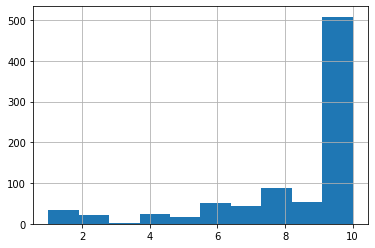

In [27]:
df.score.hist();

In [28]:
# 관람객 평점 : 8.30
# score가 평균보다 높으면 긍정적인 반응으로 보고, 평균보다 낮으면 부정적인 반응으로 분류
# score 데이터 이진 변환

def rating_to_label(rating):
    if rating > 8.3:
        return 1
    else:
        return 0

df['is_positive'] = df['score'].apply(lambda x: rating_to_label(x))

In [29]:
df.head()

,score,comment,is_positive
0,10,최민식이 열고 최민식이 닫았다....,1
1,10,파이송 OST 음원 내줘요....,1
2,10,"어쩌면 뻔한 스토리일지도 모르지만, 우리가 원하는 세상을 이야기하는 동화. 난롯가처...",1
3,7,초반엔 상당히 신선했는데 말이죠... 리학성의 사연이 드러나면서 부터는 뻔한 결말로...,0
4,10,역시 최민식! 올해 본 영화 중 제일 감동적이고 재밌었어요,1


In [30]:
df.is_positive.value_counts()

1    562
0    282
Name: is_positive, dtype: int64

학습/테스트 데이터 분리

In [31]:
from sklearn.model_selection import train_test_split

y = df['is_positive']
x_train, x_test, y_train, y_test = train_test_split(tf_idf_vect, y, test_size=0.2, stratify=y)

In [32]:
print(x_train.shape)
print(x_test.shape)

(675, 1235)
(169, 1235)


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Logistic Regression 모델 학습
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

# 분류 예측 결과
y_pred = lr.predict(x_test)

모델 성능 측정

In [34]:
from sklearn.metrics import accuracy_score, classification_report

In [35]:
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))
print("="*60)
print(classification_report(y_test, y_pred))

Accuracy score: 0.6923076923076923
              precision    recall  f1-score   support

           0       0.75      0.11      0.19        56
           1       0.69      0.98      0.81       113

    accuracy                           0.69       169
   macro avg       0.72      0.54      0.50       169
weighted avg       0.71      0.69      0.60       169



## (4) 분석 결과 정리

### 4-1. coef값 시각화

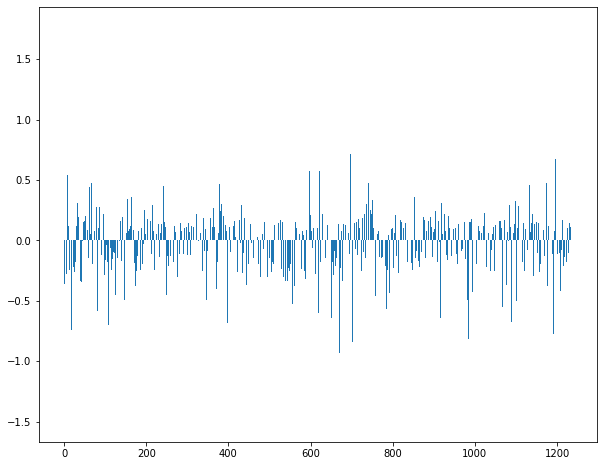

In [36]:
# 길이가 짧은 선은 긍정과 부정 모두에 나타나는 단어

plt.figure(figsize=(10,8))
plt.bar(range(len(lr.coef_[0])), lr.coef_[0]);

### 4-2. 긍정/부정 키워드 출력

In [37]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(1.7691224266397971, 433), (1.3878850793706592, 1052), (1.2007646983461142, 851), (1.0215249342122492, 1064), (1.0055192060790836, 21)]
[(-1.4041235862576724, 277), (-1.408591415749187, 1224), (-1.409799614990954, 477), (-1.4696392182077025, 445), (-1.5042014672958743, 1046)]


In [38]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=False)

In [39]:
coef_pos_index[:10]

[(1.7691224266397971, 433),
 (1.3878850793706592, 1052),
 (1.2007646983461142, 851),
 (1.0215249342122492, 1064),
 (1.0055192060790836, 21),
 (0.9847306347712282, 324),
 (0.9452297173565747, 766),
 (0.9252635791954648, 576),
 (0.7922309699754648, 684),
 (0.7590199800263068, 523)]

In [40]:
coef_neg_index[:10]

[(-1.5042014672958743, 1046),
 (-1.4696392182077025, 445),
 (-1.409799614990954, 477),
 (-1.408591415749187, 1224),
 (-1.4041235862576724, 277),
 (-1.2460518848338875, 895),
 (-1.132836086425915, 20),
 (-0.9631631986383313, 988),
 (-0.9348129488018039, 670),
 (-0.9136844482550546, 197)]

In [41]:
# {벡터:단어} 맵핑

vector_word_dictionary = {v: k for k, v in vect.vocabulary_.items()}

In [42]:
for index, (key, value) in enumerate(vector_word_dictionary.items()):
    if index >= 10:
        break
    else:
        print(index, key, value)

0 1057 최민식
1 1106 파이송
2 781 음원
3 667 어쩌면
4 588 스토리
5 844 일지
6 750 우리
7 552 세상
8 806 이야기
9 269 동화


In [43]:
for coef in coef_pos_index[:10]:
    print(vector_word_dictionary[coef[1]], coef[0])

배우 1.7691224266397971
최고 1.3878850793706592
자극 1.2007646983461142
추천 1.0215249342122492
감동 1.0055192060790836
마음 0.9847306347712282
위로 0.9452297173565747
수학 0.9252635791954648
여운 0.7922309699754648
생각 0.7590199800263068


In [44]:
for coef in coef_neg_index[:10]:
    print(vector_word_dictionary[coef[1]], coef[0])

초반 -1.5042014672958743
별로 -1.4696392182077025
북한 -1.409799614990954
후반 -1.408591415749187
드라마 -1.4041235862576724
전개 -1.2460518848338875
감독 -1.132836086425915
중반 -0.9631631986383313
억지 -0.9348129488018039
노잼 -0.9136844482550546


### 4-3. 텍스트 감정 분석 결과

긍정적 반응 분석

긍정적인 리뷰를 남긴 사람들은 '최고', '감동', '생각' 등의 단어들을 가장 많이 사용했습니다. 이와 함께 많이 사용한 단어인 '자극', '배우', '연기력', '파이송' 등의 단어들을 고려하여 종합적으로 판단했을 때, 자극적이지 않으면서도 감동을 주는 스토리라인을 높게 평가했던 사람들이 긍정적으로 반응한 것으로 보입니다. 배우들의 연기력을 높게 평가했던 사람들이 많으며, 극중에 나온 '파이송'이 긍정적인 반응을 이끌어냈다는 점도 주목할 요소입니다.

부정적 반응 분석

부정적인 리뷰를 남긴 사람들은 '드라마', '별로', '전개' 등의 단어들을 가장 많이 사용했습니다. 영화의 초반/중반/후반부를 구분했던 리뷰가 많은 것으로 보았을 때, 부정적인 반응을 보였던 사람들 대부분 영화 전반에 걸친 불만보다는 일부 요소에 대한 불만족을 점수에 반영한 것으로 보입니다. 특히 기존에 TV에서 방영되었던 일부 드라마와 스토리 전개가 비슷하다는 점, 탈북자를 수학의 천재로 묘사하여 북한을 미화한 것으로 느껴지는 요소가 있다는 점 등이 부정적 반응을 이끌어낸 요소로 꼽혔습니다.